In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import LabelEncoder
pd.set_option('max_columns', None)
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data = pd.read_csv('G:/kaggle竞赛GM之路！！！/竞赛ing/2021CCF个贷违约预测/submit_12/nw_train_public.csv')
test_public = pd.read_csv('G:/kaggle竞赛GM之路！！！/竞赛ing/2021CCF个贷违约预测/test_public.csv')
train_inte = pd.read_csv('G:/kaggle竞赛GM之路！！！/竞赛ing/2021CCF个贷违约预测/train_internet.csv')

In [3]:
def train_model(data_, test_, y_, folds_):
    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault'] ]
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        clf = LGBMClassifier(
            n_estimators=4000,
            learning_rate=0.08,
            num_leaves=2**5,
            colsample_bytree=.65,
            subsample=.9,
            max_depth=5,
#             max_bin=250,
            reg_alpha=.3,
            reg_lambda=.3,
            min_split_gain=.01,
            min_child_weight=2,
            silent=-1,
            verbose=-1,
        )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=40  #30
               )

        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['isDefault'] = sub_preds

    return oof_preds, test_[['loan_id', 'isDefault']], feature_importance_df

In [4]:
def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

In [5]:
def workYearDIc(x):
    if str(x)=='nan':
        return -1
    x = x.replace('< 1','0')
    return int(re.search('(\d+)', x).group())

def findDig(val):
    fd = re.search('(\d+-)', val)
    if fd is None:
        return '1-'+val
    return val + '-01'


class_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}
timeMax = pd.to_datetime('1-Dec-21')
train_data['work_year'] = train_data['work_year'].map(workYearDIc)
test_public['work_year'] = test_public['work_year'].map(workYearDIc)
train_data['class'] = train_data['class'].map(class_dict)
test_public['class'] = test_public['class'].map(class_dict)

train_data['earlies_credit_mon'] = pd.to_datetime(train_data['earlies_credit_mon'].map(findDig))
test_public['earlies_credit_mon'] = pd.to_datetime(test_public['earlies_credit_mon'].map(findDig))
train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+  pd.offsets.DateOffset(years=-100)  
test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+ pd.offsets.DateOffset(years=-100)
train_data['issue_date'] = pd.to_datetime(train_data['issue_date'])
test_public['issue_date'] = pd.to_datetime(test_public['issue_date'])



#Internet数据处理
train_inte['work_year'] = train_inte['work_year'].map(workYearDIc)
train_inte['class'] = train_inte['class'].map(class_dict)
train_inte['earlies_credit_mon'] = pd.to_datetime(train_inte['earlies_credit_mon'])
train_inte['issue_date'] = pd.to_datetime(train_inte['issue_date'])


train_data['issue_date_month'] = train_data['issue_date'].dt.month
test_public['issue_date_month'] = test_public['issue_date'].dt.month
train_data['issue_date_dayofweek'] = train_data['issue_date'].dt.dayofweek
test_public['issue_date_dayofweek'] = test_public['issue_date'].dt.dayofweek

train_data['earliesCreditMon'] = train_data['earlies_credit_mon'].dt.month
test_public['earliesCreditMon'] = test_public['earlies_credit_mon'].dt.month
train_data['earliesCreditYear'] = train_data['earlies_credit_mon'].dt.year
test_public['earliesCreditYear'] = test_public['earlies_credit_mon'].dt.year


###internet数据

train_inte['issue_date_month'] = train_inte['issue_date'].dt.month
train_inte['issue_date_dayofweek'] = train_inte['issue_date'].dt.dayofweek
train_inte['earliesCreditMon'] = train_inte['earlies_credit_mon'].dt.month
train_inte['earliesCreditYear'] = train_inte['earlies_credit_mon'].dt.year


cat_cols = ['employer_type', 'industry']

from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder().fit(train_data[col])
    train_data[col] = lbl.transform(train_data[col])
    test_public[col] = lbl.transform(test_public[col])
    
    #Internet处理
    train_inte[col] = lbl.transform(train_inte[col])
    
# 'f1','policy_code','app_type' 这三个去掉是881
# ,'f1','policy_code','app_type'
col_to_drop = ['issue_date', 'earlies_credit_mon']
train_data = train_data.drop(col_to_drop, axis=1)
test_public = test_public.drop(col_to_drop, axis=1 )

##internet处理
train_inte = train_inte.drop(col_to_drop, axis=1 )
# 暂时不变
# train_inte = train_inte.rename(columns={'is_default':'isDefault'})
# data = pd.concat( [train_data,test_public] )
tr_cols = set(train_data.columns)
same_col = list(tr_cols.intersection(set(train_inte.columns)))
train_inteSame = train_inte[same_col].copy()

Inte_add_cos = list(tr_cols.difference(set(same_col)))
for col in Inte_add_cos:
    train_inteSame[col] = np.nan

In [6]:
#预测train_public并提取概率阈值0.4以内的数据

y = train_data['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=0)
oof_preds, IntePre, importances = train_model(train_data, train_inteSame, y, folds)

IntePre['isDef'] = train_inte['is_default']
from sklearn.metrics import roc_auc_score
roc_auc_score(IntePre['isDef'],IntePre.isDefault)
## 选择阈值0.4，从internet表中提取预测小于该概率的样本，并对不同来源的样本赋予来源值
InteId = IntePre.loc[IntePre.isDefault<0.4, 'loan_id'].tolist()

train_data['dataSourse'] = 1
test_public['dataSourse'] = 1
train_inteSame['dataSourse'] = 0
train_inteSame['isDefault'] = train_inte['is_default']
use_te = train_inteSame[train_inteSame.loan_id.isin( InteId )].copy()

train = pd.concat([ train_data,use_te]).reset_index(drop=True)
test  = test_public.copy()


# IntePre.isDefault
plt.figure(figsize=(16,6))
plt.title("Distribution of Default values IntePre")
sns.distplot(IntePre['isDefault'],color="black", kde=True,bins=120, label='train_data')
# sns.distplot(train_inte[col],color="red", kde=True,bins=120, label='train_inte')
plt.legend();plt.show()


del train_data,test_public

Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.964802	training's binary_logloss: 0.170532	valid_1's auc: 0.918142	valid_1's binary_logloss: 0.219824
Early stopping, best iteration is:
[70]	training's auc: 0.954468	training's binary_logloss: 0.183814	valid_1's auc: 0.918754	valid_1's binary_logloss: 0.21944
Fold  1 AUC : 0.918754
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[56]	training's auc: 0.949563	training's binary_logloss: 0.188355	valid_1's auc: 0.910659	valid_1's binary_logloss: 0.226247
Fold  2 AUC : 0.910659
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[40]	training's auc: 0.943683	training's binary_logloss: 0.198817	valid_1's auc: 0.90687	valid_1's binary_logloss: 0.230969
Fold  3 AUC : 0.906870
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.964201	training's binary_logloss: 0.169894	valid_1's auc: 0

In [7]:
print(IntePre[IntePre['isDefault']>0.4]['isDefault'].count()/IntePre['isDefault'].count())
t_t = train_inte.copy()
t_t['inte_pred'] = IntePre['isDefault']
plt.hist(t_t[t_t['is_default']==0]['inte_pred'],50)
plt.hist(t_t[t_t['is_default']==1]['inte_pred'],50)
plt.show()

0.3463946666666667


In [8]:
y = train['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=0)
oof_preds, test_preds, importances = train_model(train, test, y, folds)

Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.789394	training's binary_logloss: 0.309627	valid_1's auc: 0.783962	valid_1's binary_logloss: 0.310055
[200]	training's auc: 0.798779	training's binary_logloss: 0.304921	valid_1's auc: 0.787396	valid_1's binary_logloss: 0.308251
[300]	training's auc: 0.805285	training's binary_logloss: 0.301664	valid_1's auc: 0.788826	valid_1's binary_logloss: 0.307567
[400]	training's auc: 0.811289	training's binary_logloss: 0.298618	valid_1's auc: 0.789751	valid_1's binary_logloss: 0.307148
[500]	training's auc: 0.816488	training's binary_logloss: 0.295915	valid_1's auc: 0.790156	valid_1's binary_logloss: 0.306963
Early stopping, best iteration is:
[509]	training's auc: 0.817007	training's binary_logloss: 0.295641	valid_1's auc: 0.790219	valid_1's binary_logloss: 0.306933
Fold  1 AUC : 0.790219
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.78873	training's binary_logloss: 0.30938

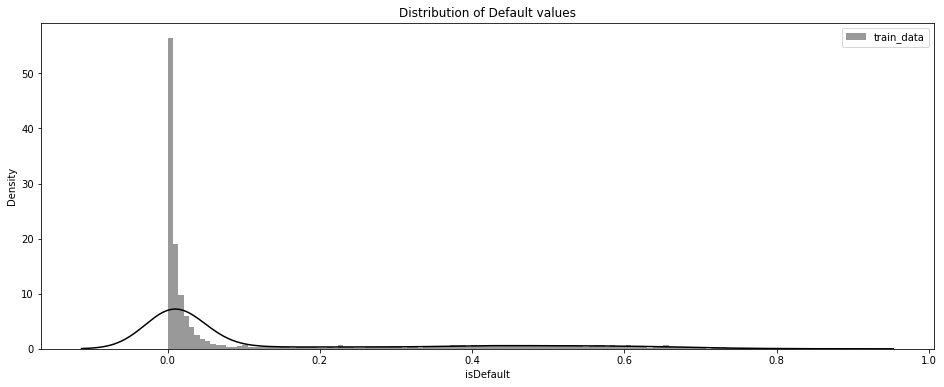

In [9]:
#看一下test_public的isDefault的概率分布
test['isDefault'] = test_preds['isDefault']
plt.figure(figsize=(16,6))
plt.title("Distribution of Default values")
sns.distplot(test['isDefault'],color="black", kde=True,bins=120, label='train_data')
plt.legend();plt.show()

In [10]:
print(test[test['isDefault']>0.50]['isDefault'].count())
print(test[test['isDefault']>0.20]['isDefault'].count())

516
1185


In [11]:
test_preds.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('G:/kaggle竞赛GM之路！！！/竞赛ing/2021CCF个贷违约预测/submit_12/submission.csv', index=False)